# <center>HW 1 for Computer Vision</center>

<center>杜闻博 18307110359;  2022.03.24</center>

本报告由 jupter notebook 自动生成，实验[代码（及模型）见 GitHub repo](https://github.com/DWB1115/DATA130051/tree/main/ass%201)，储存的[模型及代码备用链接见 Google Drive](https://drive.google.com/drive/folders/1-7XOAJE1OAfjnXzxTaxaxktGXcCXC_qO)。在之后的报告中将展示代码的结构与模型的训练、储存等细节，并展示模型参数的可视化、模型效果等。本实验中部分代码参照了[cs231n Assignment 1](https://cs231n.github.io/assignments2021/assignment1/)（代码由本人自己实现）。

## 代码框架说明
- `./utils/load_data.py`：载入 `tensorflow.keras` 中的 MNIST 数据，并将其划为指定数目的训练集、验证集、测试集。
- `./utils/self_np_network.py`：实现了仅使用 `numpy` 数组的神经网络单元（包括前向和反向），以及基于此实现的一个使用 ReLU 激活函数的2层全连接神经网络。
- `./utils/optim.py`：定义了优化函数中最小化损失函数的优化方法，在本次实验中仅实现了随机梯度下降（SGD），但也可以扩充其他可能的方法。
- `./utils/solver.py`：定义了训练模型的类，接收模型与数据，并将其进行训练。
- `./utils/gradient_check.py`：检查函数返回的梯度与数值计算梯度之间的误差，用来检测代码是否正确返回所需的梯度值。
- `./utils/vis_utils.py`：帮助绘制神经网络每一层的参数。

## 核心代码说明与检查

### 初始化并载入数据
从 `tensorflow.keras` 载入数据，并分割为训练集、验证集、测试集，可视化部分训练样本。

In [64]:
# a bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from utils.self_np_network import *
from utils.load_data import get_MNIST_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# Load the MNIST data.
data = get_MNIST_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 28, 28))
('y_train: ', (49000,))
('X_val: ', (1000, 28, 28))
('y_val: ', (1000,))
('X_test: ', (1000, 28, 28))
('y_test: ', (1000,))


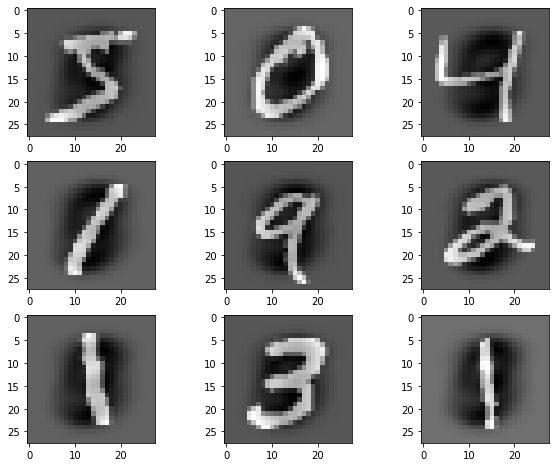

In [66]:
# show some samples from the MNIST dataset
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(data['X_train'][i], cmap=plt.get_cmap('gray'))
plt.show()

### affine-ReLU 层的前向传播与反向传播
检查 `./utils/self_np_network.py` 中实现的，使用 ReLU 激活函数的 affine 层神经网络在前向传播与反向传播时代码的正确性。

In [67]:
# Test the relu_forward function
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


In [68]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


In [69]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


### 损失层的实现（svm损失与softmax损失）
检查 `./utils/self_np_network.py` 中实现的，使用 svm 损失，以及使用 softmax 损失的损失层神经网络的实现正确性。

In [70]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


### 网络的搭建与训练

#### Two-layer network 的搭建
`./utils/self_np_network.py` 中实现的类 `TwoLayerNet` 如下所示，其由 affine - relu - affine - softmax 构成，因为我们也实现了 svm 损失函数，因此其最后一层也可以改为取 svm 损失。该类的定义如下所示（正则化强度由参数 self.reg 控制）：

```python
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. 

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement Gradient Descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.
    """

    def __init__(
        self,
        input_dim=28 * 28,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,):
        ...
```

其中为了方便模型的保存与载入，自己定义了模型的保存与载入方法：
```python
class TwoLayerNet(object):
    def __init__(
        self,
        input_dim=28 * 28,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,):
      ...


    def loss(self, X, y=None):
      ...

    def save(self,path):
        obj = pickle.dumps(self)
        with open(path,"wb") as f:
            f.write(obj)

    def load(path):
      obj = None
        with open(path, "rb") as f:
            try:
                obj = pickle.load(f)
            except:
                print("IOError")
        return obj
```

#### Two-layer network 的训练
`./utils/solver.py` 中实现的类 `Solver` 如下所示，其选择一种优化算法，来为神经网络模型实现参数训练，注意其并非只适配与前述双层神经网络，该 Solver 类可以为任何类型的神经网络进行参数优化。该类的定义如下所示（其中实现了学习率下降，由参数 self.lrdecay 控制）：

```python
class Solver(object):
    """
      Example usage might look something like this:

      data = {
        'X_train': # training data
        'y_train': # training labels
        'X_val': # validation data
        'y_val': # validation labels
      }

      model = MyAwesomeModel(hidden_size=100, reg=10)

      solver = Solver(model, data,
                      update_rule='sgd',
                      optim_config={
                        'learning_rate': 1e-3,
                      },
                      lr_decay=0.95,
                      num_epochs=10, batch_size=100,
                      print_every=100)
      solver.train()
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images
        
        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        ...
```

#### SGD 优化算法的实现
`./utils/solver.py` 中实现的类 `Solver` 由 `./utils/optim.py` 中定义的优化算法进行优化。本实验中我仅实现了 SGD 算法，其定义如下所示：

```python
def sgd(w, dw, config=None):
    """
        Performs vanilla stochastic gradient descent.

        config format:
        - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)

    w -= config["learning_rate"] * dw

    return w, config
```

## 模型的生成、训练、保存
使用前文提到的类 `TwoLayerNet` 与类 `Solver`，对模型进行搭建与训练、保存，如下所示：

In [75]:
input_size = 28 * 28
hidden_size = 100
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes, reg=0.1)
solver = Solver(model, 
                data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=15, batch_size=100,
                print_every=500, verbose = True)
solver.train()

(Iteration 1 / 7350) loss: 2.304059
(Epoch 0 / 15) train acc: 0.148000; val_acc: 0.145000
(Epoch 1 / 15) train acc: 0.940000; val_acc: 0.908000
(Iteration 501 / 7350) loss: 0.294608
(Epoch 2 / 15) train acc: 0.963000; val_acc: 0.929000
(Iteration 1001 / 7350) loss: 0.150639
(Epoch 3 / 15) train acc: 0.961000; val_acc: 0.933000
(Iteration 1501 / 7350) loss: 0.102729
(Epoch 4 / 15) train acc: 0.970000; val_acc: 0.942000
(Iteration 2001 / 7350) loss: 0.092758
(Epoch 5 / 15) train acc: 0.970000; val_acc: 0.949000
(Iteration 2501 / 7350) loss: 0.083560
(Epoch 6 / 15) train acc: 0.981000; val_acc: 0.953000
(Iteration 3001 / 7350) loss: 0.155097
(Epoch 7 / 15) train acc: 0.974000; val_acc: 0.952000
(Iteration 3501 / 7350) loss: 0.120507
(Epoch 8 / 15) train acc: 0.979000; val_acc: 0.948000
(Iteration 4001 / 7350) loss: 0.066014
(Epoch 9 / 15) train acc: 0.982000; val_acc: 0.952000
(Iteration 4501 / 7350) loss: 0.116702
(Epoch 10 / 15) train acc: 0.988000; val_acc: 0.956000
(Iteration 5001 / 7

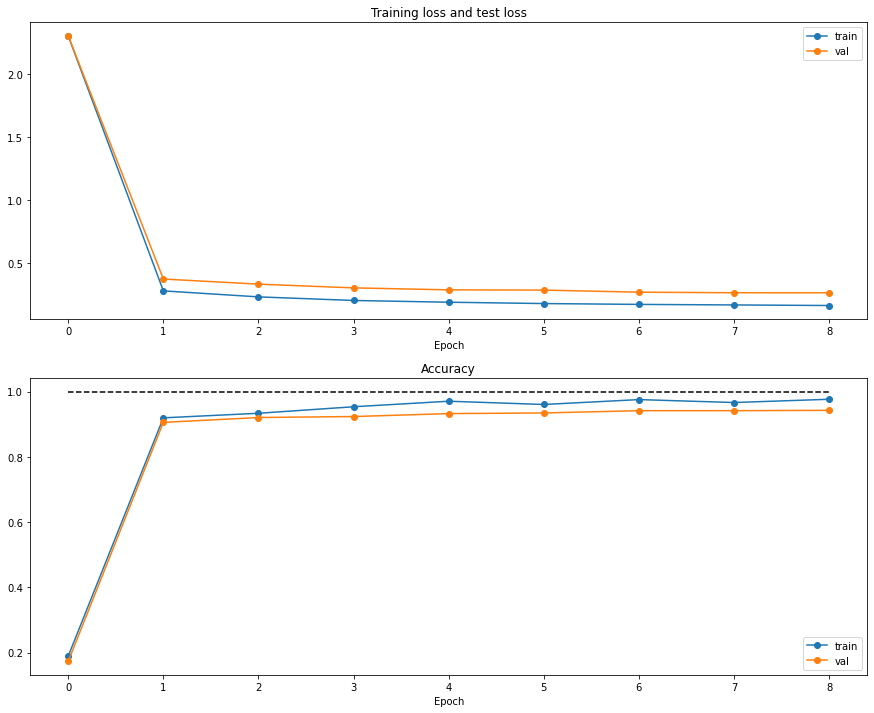

In [87]:
# Run this cell to visualize training / val loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss and test loss')
plt.plot(solver.train_loss_history, '-o', label='train')
plt.plot(solver.val_loss_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([1.0] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

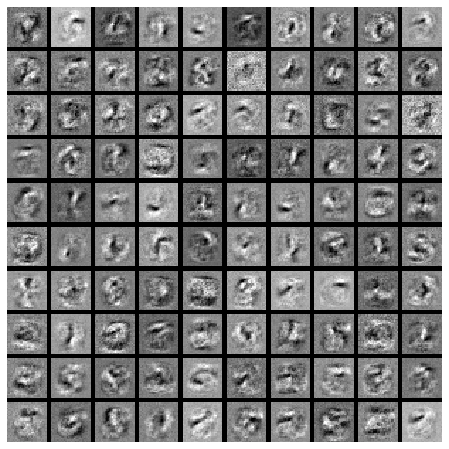

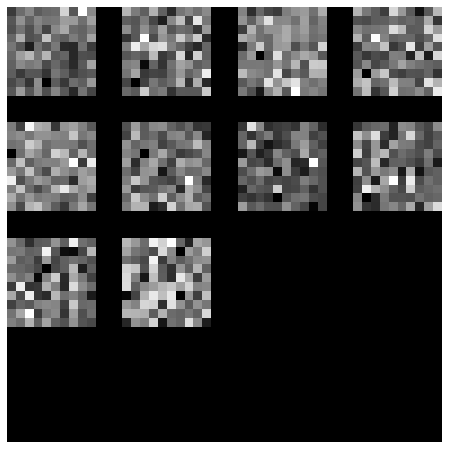

In [79]:
from utils.vis_utils import visualize_grid
# Visualize the weights of the network for per layer
def show_net_weights_W1(net):
    W_show = net.params["W1"]
    W_show = W_show.reshape(28, 28, 1, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W_show, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

def show_net_weights_W2(net):
    W_show = net.params["W2"]
    W_show = W_show.reshape(10, 10, 1, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W_show, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights_W1(model)
show_net_weights_W2(model)

In [80]:
# save model
model.save("TwolayerNet.model")

## 参数查找
对于隐藏层大小，学习率，正则化系数进行参数查找，寻找一个在验证集上表现最优的组合，并保存。


In [83]:
best_model = None
best_val_accuracy = 0.0
def random_choose_hyperparams(hsize_values, lr_values, reg_values):
    hsize = hsize_values[np.random.randint(0,len(hsize_values))]
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    return hsize, lr, reg


input_size = 28 * 28
num_classes = 10

for i in range(10):
    solver = None
    hsize, lr, reg = random_choose_hyperparams([50, 80, 100, 120],
                                               [5e-5, 1e-4, 5e-4, 1e-3],
                                               [0.05, 0.1, 0.2])
    net = TwoLayerNet(input_size, hsize, num_classes, reg = reg)
    solver = Solver(net, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': lr,
                    },
                    lr_decay=0.95,
                    num_epochs=8, batch_size=100,
                    print_every=200, verbose = False)
    solver.train()
    print(hsize, lr, reg)
    print('Validation accuracy: ', solver.best_val_acc)
    if solver.best_val_acc > best_val_accuracy:
        best_val_accuracy = solver.best_val_acc
        best_model = net

print('Validation accuracy: ', best_val_accuracy)

100 0.001 0.05
Validation accuracy:  0.961
120 0.0005 0.1
Validation accuracy:  0.945
120 0.0005 0.1
Validation accuracy:  0.948
120 0.001 0.05
Validation accuracy:  0.953
120 5e-05 0.05
Validation accuracy:  0.873
100 5e-05 0.2
Validation accuracy:  0.869
50 0.001 0.05
Validation accuracy:  0.945
100 0.001 0.2
Validation accuracy:  0.959
80 0.0005 0.2
Validation accuracy:  0.943
50 0.001 0.2
Validation accuracy:  0.943
Validation accuracy:  0.961


In [84]:
# save model
best_model.save("best_TwolayerNet.model")

## 模型测试
载入刚刚储存的，使用参数查找后的模型对测试集的数据进行预测，并进行展示。

In [85]:
my_model = TwoLayerNet.load("./best_TwolayerNet.model")
y_val_pred = np.argmax(my_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.961


In [86]:
y_test_pred = np.argmax(my_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.971


可以看到，该模型在验证集上的精确度为 96.1%，在测试集上的精确度为 97.1%，甚至高于验证集，表现十分良好。